# Title: <hr> Introduction

400 word introduction for the topic with 2 cited studies

200 word introduction for the 

<hr>

# Methods & Results

In [1]:
library(tidyverse)
# library(repr)
library(tidymodels)
# library(rvest)
# library(stringr)
# library(DBI)
# library(dbplyr)
# library(GGally)
options(repr.matrix.max.rows = 6)
SEED <- 999

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
column_names<-c('X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
                'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
                'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
                'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
                'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
                'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59','X60', 'type')
sonar_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
                        col_names = column_names) |>
              mutate(type = as.factor(type),
                     obs = 1:n())
sonar_data_long <- pivot_longer(sonar_data,
                                cols = X01:X60,
                                values_to = "magnitude",
                                names_to  = "time") # give a better name

Rows: 208 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): type
dbl (60): X01, X02, X03, X04, X05, X06, X07, X08, X09, X10, X11, X12, X13, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


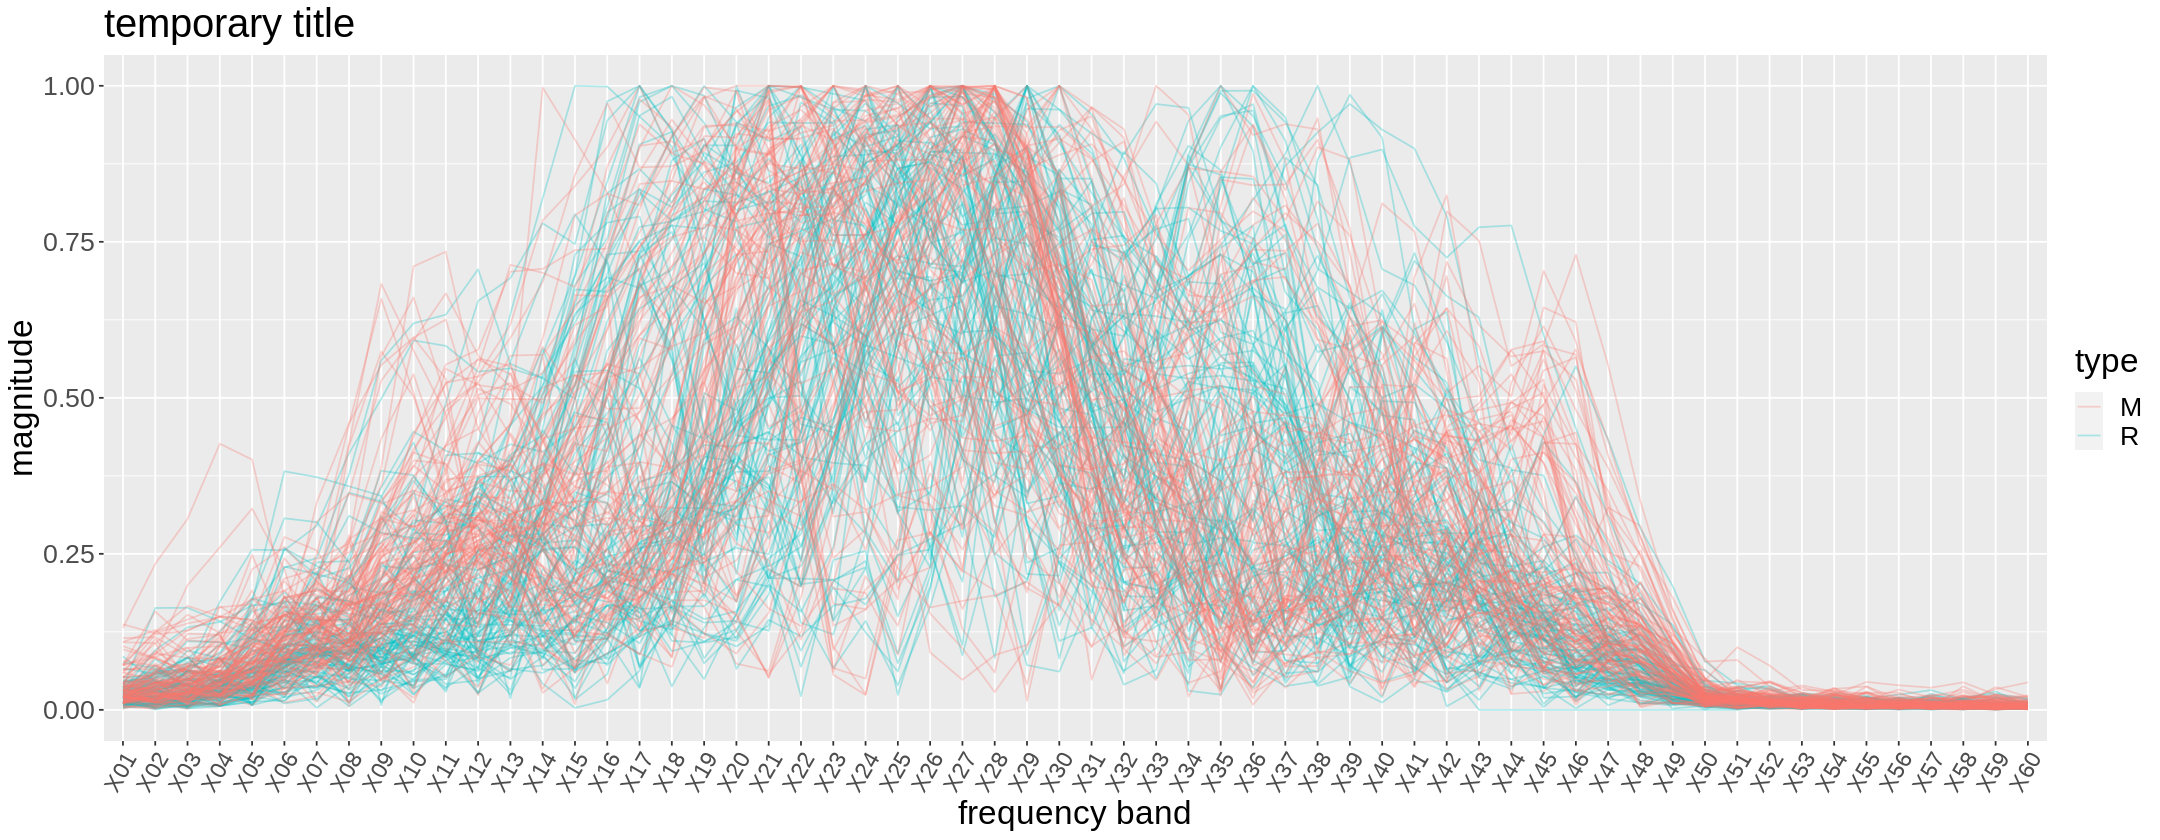

In [3]:
options(repr.plot.width=18,repr.plot.height=7)
ex <- ggplot(sonar_data_long, aes(x = time, y = magnitude)) +
        geom_line(aes(color = type, group = obs), alpha=0.3) +
        theme(text=element_text(size=20),
              axis.text.x = element_text(angle = 60, vjust = 1, hjust=1, size = 14)) +
        labs(x="frequency band") +
        ggtitle("temporary title")
ex

mine seems to end abrubptly from x45 to x50 compared to rock which is much more smooth

In [4]:
set.seed(SEED)
sonar_split <- initial_split(sonar_data, prop = 0.75, strata = type)
sonar_train <- training(sonar_split)
sonar_test <- testing(sonar_split) 

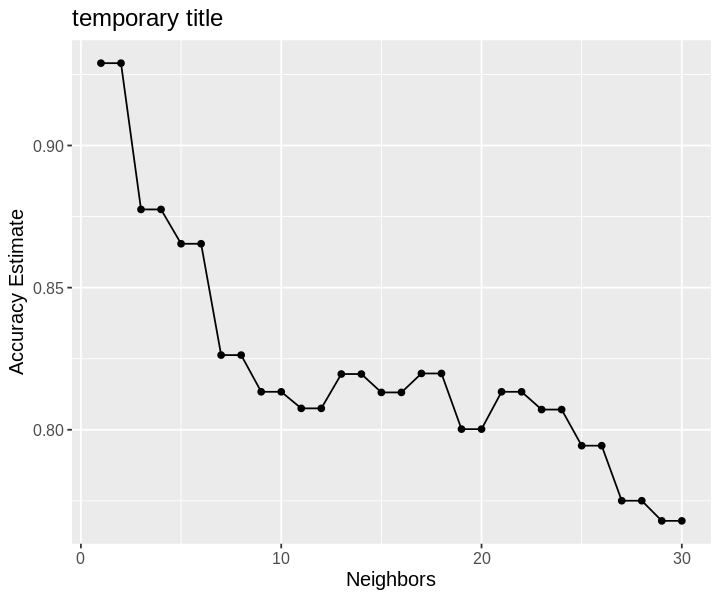

In [5]:
set.seed(SEED) 
options(repr.plot.height = 5, repr.plot.width = 6)

cross_val_recipe <- recipe(type ~ ., data = sonar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

cross_val_vfold <-  vfold_cv(sonar_train, strata = type,v = 5)

k_lots <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
  add_recipe(cross_val_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cross_val_vfold, grid = k_lots) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k_lots <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
    ggtitle("temporary title")

accuracy_vs_k_lots

In [6]:
k <- 2

best_knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors = k) |>
                 set_engine("kknn") |>
                 set_mode("classification")

best_fit <- workflow() |>
  add_recipe(cross_val_recipe) |>
  add_model(best_knn_spec) |>
  fit(data = sonar_train)

best_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1096774
Best kernel: rectangular
Best k: 2

In [7]:
sonar_test_predictions <- predict(best_fit, sonar_test) |>
  bind_cols(sonar_test)


sonar_test_predictions |>
  metrics(truth = type, estimate = .pred_class) |>
  filter(.metric == "accuracy")
print("table title")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9056604


[1] "table title"


In [8]:
confusion <- sonar_test_predictions |>
             conf_mat(truth = type, estimate = .pred_class)
confusion
print("table title")

          Truth
Prediction  M  R
         M 27  4
         R  1 21

[1] "table title"


<hr>

# Discussion

Summary of findings (300 words)
<hr>

# References

citation from intro + citation for data